In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import analysis_funcs

In [2]:
os.chdir("c:/Users/Raya/OneDrive/Documents/3-CSAI/CSAI-Y3-S2/Thesis/Replication")

# Globals

In [3]:
word_lengths = [3,4,5,6,7]
rescaling_types = ['none', 'abs', 'norm', 'ang']

random_baseline_files = {rescaling: f'results/correlations/rd_baseline/rd_bl_corrs_{rescaling}.csv' for rescaling in rescaling_types}
binned_baseline_files = {rescaling: f'results/correlations/bin_baseline/bin_bl_corrs_{rescaling}.csv' for rescaling in rescaling_types}
real_scores_files = {rescaling: f'results/correlations/real_corr_scores/real_corrs_{rescaling}.csv' for rescaling in rescaling_types}

baselines_data = {
    'random': random_baseline_files,
    'binned': binned_baseline_files
}

# Correlation within range of baseline correlations?

## Range computations

In [5]:
# For each rescaling type
    # - Get real raw and transformed corr scores
    # - For each baseline 
        # - For each word length
            # - Get range of baseline correlations
            # - Check if real correlation scores falls within that range

results = {word_length: 
    {rescaling:
        {baseline:[] 
            for baseline in baselines_data.keys()} 
        for rescaling in rescaling_types} 
    for word_length in word_lengths}


for rescaling in rescaling_types:
    # Load and extract correlation scores of real lexicon 
    real_corrs_per_wordlength = {}
    real_corr_df = analysis_funcs.load_data(real_scores_files[rescaling])
    for word_length, corr in zip(real_corr_df['word_length'], real_corr_df['transformed_corr']):
        real_corrs_per_wordlength[word_length] = corr
    
    for baseline_type, baseline_files in baselines_data.items():
        # Load the correlation data for the curernt baseline
        bl_corr_df = analysis_funcs.load_data(baselines_data[baseline][rescaling])
        
        # Iterate over word lengths
        for word_length in word_lengths:
            # Get the range of trasnformed baseline correlations and store it in the dictionary
            bl_corr_min = np.min(bl_corr_df['transformed_corr'])
            bl_corr_max = np.max(bl_corr_df['transformed_corr'])
            real_corr = real_corrs_per_wordlength[word_length]
            results[word_length][rescaling][baseline_type].extend([(bl_corr_min, bl_corr_max), real_corr])

for word_length in results.keys():
    for rescaling in results[word_length]:
        print(f"{word_length}, {rescaling}, {results[word_length][rescaling]}")

# Save the range information to a csv file for each rescaling
output_file_path = f"results/correlations/all_corr_ranges"
with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['word_length', 'rescaling', 'baseline', 'baseline_min', 'baseline_max', 'real_corr', 'is_within_range'])
    for word_length in results.keys():
        for rescaling in results[word_length]:
            for baseline, data in results[word_length][rescaling].items():
                baseline_min = data[0][0]
                baseline_max = data[0][1]
                real_corr = data[1]
                is_within_range = 'T' if real_corr < baseline_max and real_corr > baseline_min else 'F'
                csv_writer.writerow([word_length, rescaling, baseline, baseline_min, baseline_max, real_corr, is_within_range])

NameError: name 'baseline' is not defined

## Plot correlation vs. baselines

1. For each word length:
    - Compute z-score of transformed real lexicon correlation using mean & SD of correlations from random reassignments 
    - Get correlation score for real lexicon correlation
    - Transform it using Fisher z-transformation
    - Compute mean & SD of correlations from random reassignments 
    - Compute z-score & p-value of transformed real lexicon correlation

2. Plot historgram of random corrs + real corr for each word length (see Fig.3 in Dautriche et al.)

Files with results:
- Baseline: One file for each rescaling version, storing 10,000 transformed correlation scores for each word length, under the directory "results/correlations/rd_baseline"
- Real: One file for each rescaling version, storing 1 transformed correlation score for each word length, under the directory "results/correlations/real_corr_scores"

Plot layout: 
4 plots -> one for each rescaling type

Each plot has subplots:
- Rows -> word lengths
- Columns -> baseline type (random, binned)
- Each subplot contains: 
    - Histogram of transformed correlations from baseline
    - Point indicating transformed correlation score of real lexicon for the given word length and rescaling
    - Label with z-score of real lexicon correlation 
    - Star if p-value of z-score is statistically significant

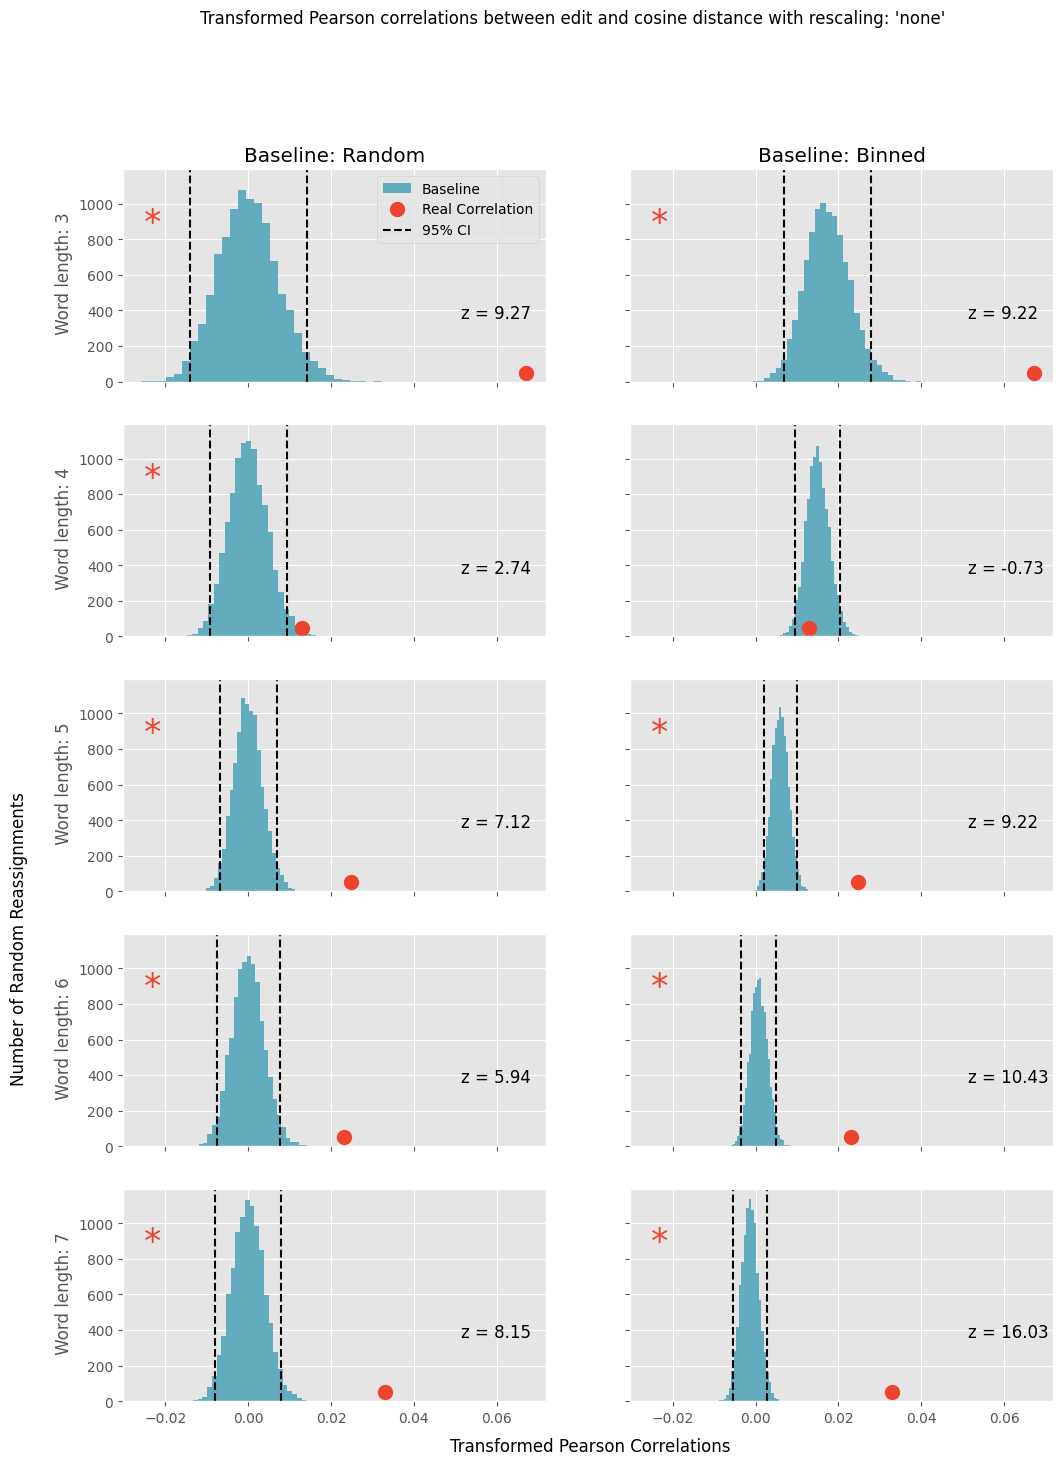

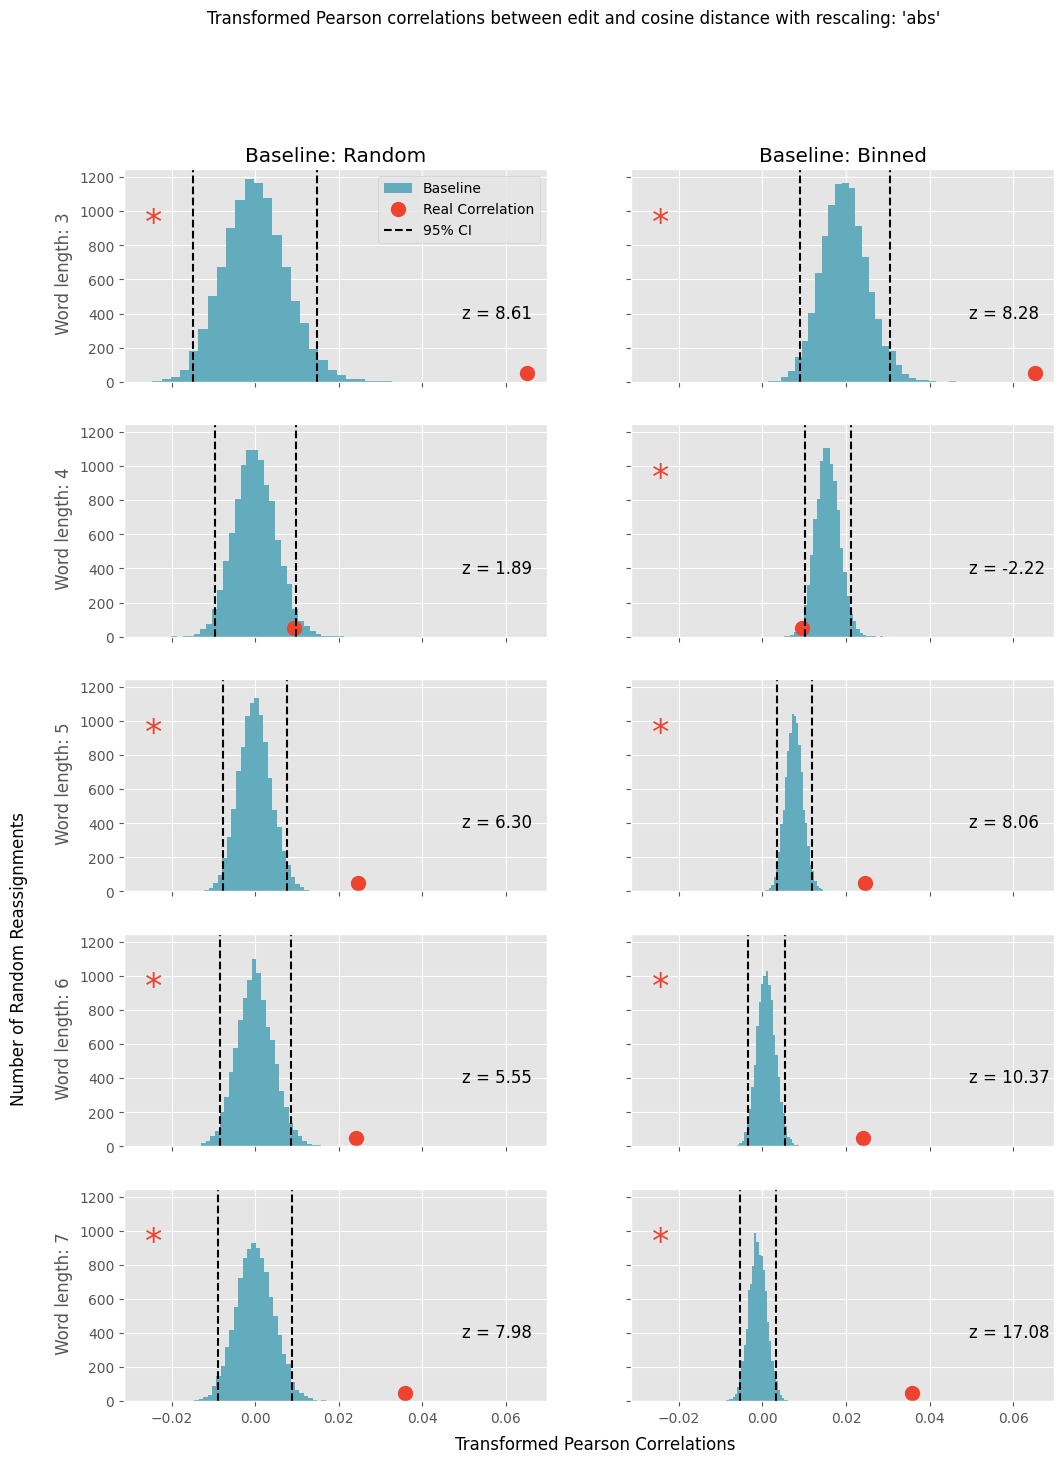

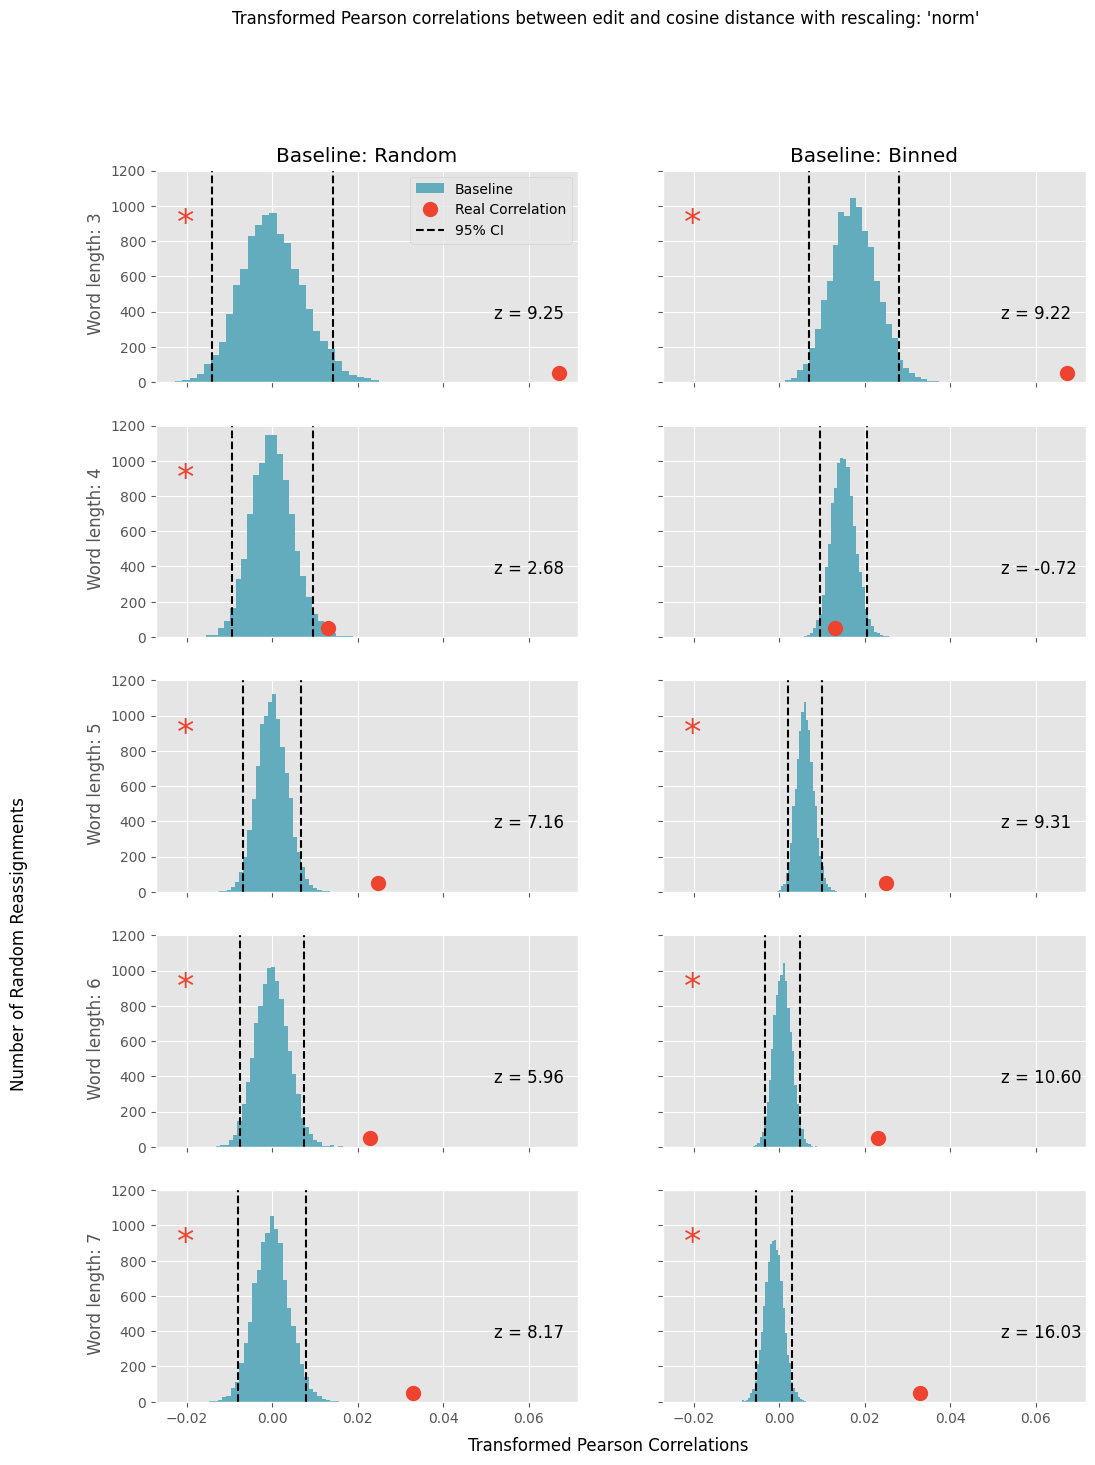

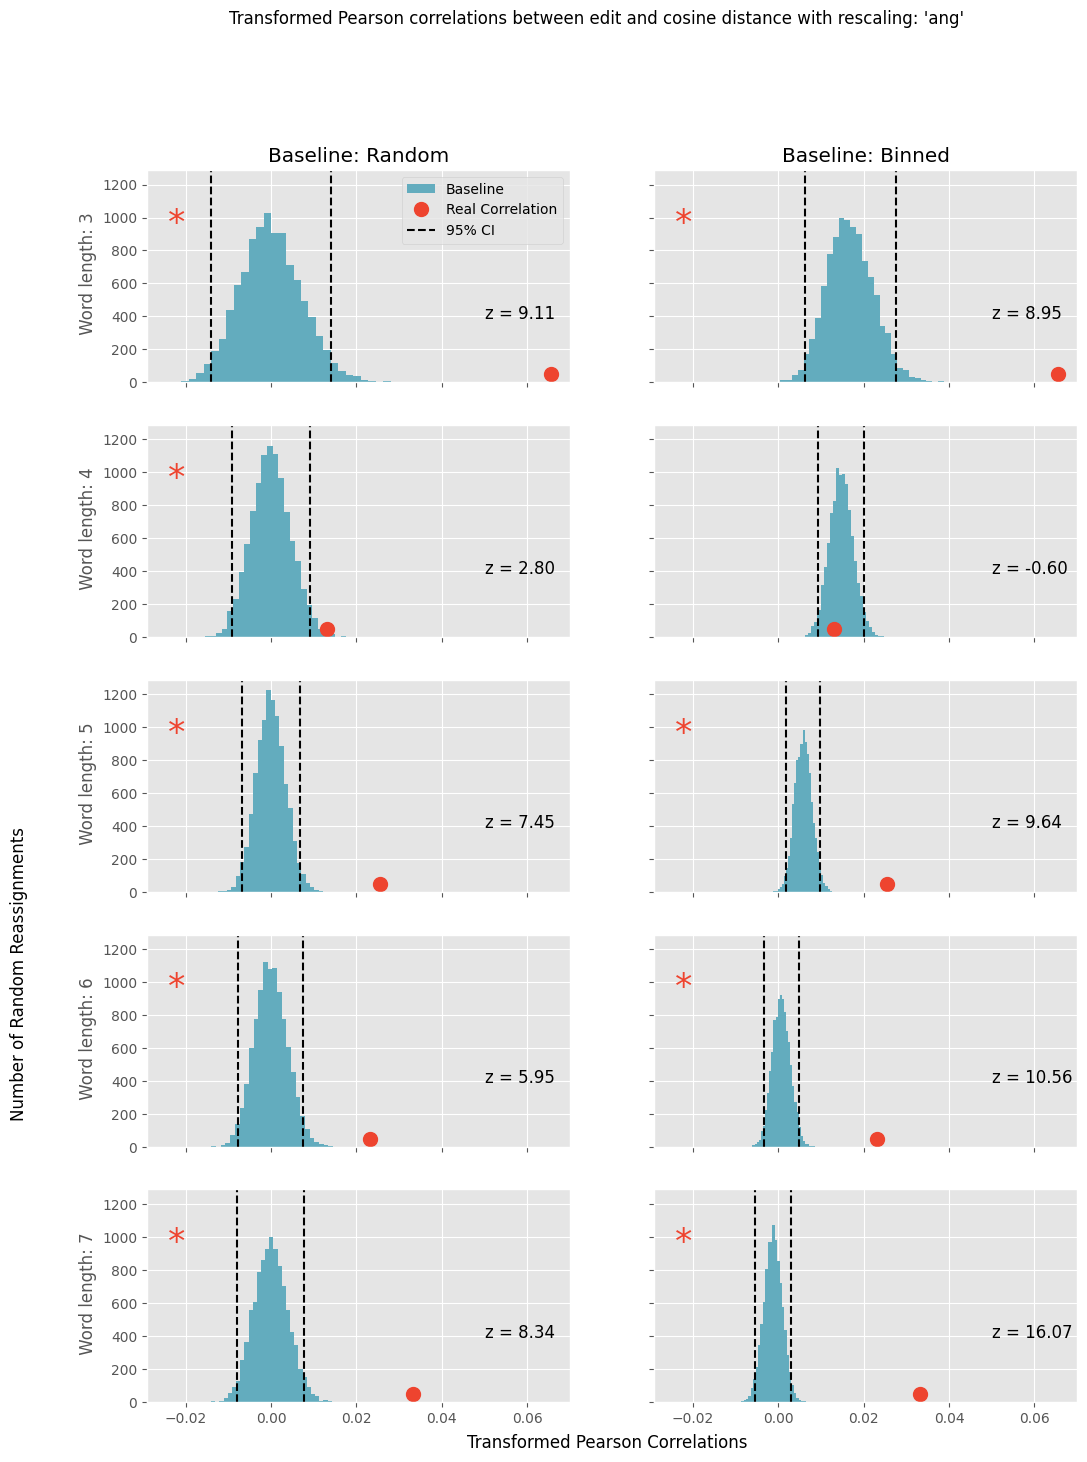

In [4]:
def plot_baseline_histograms(random_baseline_files, binned_baseline_files, real_scores_files, rescaling_types, save_fig=False):
    """
    Plot histograms of baseline (random and binned) and real correlations for each rescaling type.

    Parameters:
        random_baseline_files (dict): A dictionary with rescaling types as keys and file paths to random baseline correlation files as values.
        binned_baseline_files (dict): A dictionary with rescaling types as keys and file paths to binned baseline correlation files as values.
        real_scores_files (dict): A dictionary with rescaling types as keys and file paths to real-lexicon correlation files as values.
        rescaling_types (list): A list of rescaling types to process (with values 'none', 'abs', 'norm', 'ang').
    """
    # Define word lengths and baseline types (random and binned)
    word_lengths = [3, 4, 5, 6, 7]
    baseline_types = ['Random', 'Binned']
    
    # Iterate through each rescaling type
    for _, rescaling_type in enumerate(rescaling_types):
        # Create a figure for the grid of subplots
        plt.style.use('ggplot')
        
        fig, axes = plt.subplots(nrows=len(word_lengths), ncols=len(baseline_types), figsize=(12, 16), sharex=True, sharey=True)
        fig.suptitle(f"Transformed Pearson correlations between edit and cosine distance with rescaling: '{rescaling_type}'")
        
        # Load real lexicon correlation data
        real_file_path = real_scores_files[rescaling_type]
        df_real = analysis_funcs.load_data(real_file_path)
        
        # Iterate through each word length (rows)
        for i, word_length in enumerate(word_lengths):
            # Get the transformed real lexicon correlation for the word length
            real_corr = df_real[df_real['word_length'] == word_length]['transformed_corr'].iloc[0]
            
            # Iterate through each baseline type (columns)
            for j, baseline_type in enumerate(baseline_types):                
                # Select the appropriate file path for the current rescaling type and baseline type
                file_path = random_baseline_files[rescaling_type] if baseline_type == 'Random' else binned_baseline_files[rescaling_type]
                
                # Load baseline data
                df_baseline = analysis_funcs.load_data(file_path)
                
                # Compute mean and standard deviation of transformed correlations for the word length
                mean_corr, std_corr = analysis_funcs.compute_mean_std(df_baseline, word_length)
                # if baseline_type == 'Binned':
                #     print(f" Word length {word_length} | mean={mean_corr}, std={std_corr}")
                
                # Compute z-score and p-value for the transformed real lexicon correlation
                z_score, p_value = analysis_funcs.compute_z_score_p_value(real_corr, mean_corr, std_corr)

                ax = axes[i, j]
                
                # Plot histogram of baseline transformed correlations
                df_filtered = df_baseline[df_baseline['word_length'] == word_length]
                ax.hist(df_filtered['transformed_corr'], color= '#63acbe', bins=30, label='Baseline')
                
                # Plot real correlation as a dot
                ax.plot(real_corr, 50, "o", color="#ee442f", label='Real Correlation', markersize=10)
                
                # Calculate the 95% confidence interval
                ci_lower = mean_corr - 1.96 * std_corr
                ci_upper = mean_corr + 1.96 * std_corr
                
                # Plot vertical dotted lines for the 95% confidence interval
                ax.axvline(ci_lower, color='black', linestyle='dashed', label='95% CI')
                ax.axvline(ci_upper, color='black', linestyle='dashed')
                
                # Add labels and significance markers
                # ax.set_title(f'Word Length: {word_length}, {baseline_type} Baseline')
                # Add significance markers
                ax.text(0.8, 0.3, f'z = {z_score:.2f}', fontsize=12, transform=ax.transAxes)
                if p_value < 0.05:
                    ax.text(0.05, 0.7, '*', color='#ee442f', fontsize=25, transform=ax.transAxes)

                # Add legend to the top-left subplot
                if i == 0 and j == 0:
                    ax.legend()
        
                if i == 4 and j == 1:
                    # Add common axes labels
                    ax.text(-0.04, -280, 'Transformed Pearson Correlations', fontsize=12, ha='center')
                    ax.text(-0.18, 2600, 'Number of Random Reassignments',  fontsize=12, va='center', rotation='vertical')
                
        # Add row and columns headers
        for ax, col_header in zip(axes[0], baseline_types):
            ax.set_title(f"Baseline: {col_header}")
        
        for ax, row_header in zip(axes[:,0], word_lengths):
            ax.set_ylabel(f" Word length: {row_header}")
        
        if save_fig:
            filename = f"hist_baseline"
            plt.savefig(os.path.join("plots", filename))
        else:
            plt.show()


plot_baseline_histograms(random_baseline_files, binned_baseline_files, real_scores_files, rescaling_types)